Config

In [46]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import os, warnings

from PIL import Image

Load Data

In [2]:
train_dir = 'C:/Pavel/PythonProject/II_project/train_images'

In [3]:
batch_size = 16
img_dim = 128
RESCALE = 1.0/255

VALIDATION_SPLIT = 0.1
SEED = 42

warnings.filterwarnings("ignore") 

In [4]:
img_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=RESCALE,                   
    validation_split=VALIDATION_SPLIT,  
    rotation_range=5,                 
    shear_range=0.3,                   
    zoom_range=0.3,                    
    width_shift_range=0.05,            
    height_shift_range=0.05,            
    horizontal_flip=True,               
    vertical_flip=True,                 
)

In [5]:

ds_train = img_datagen.flow_from_directory(
    train_dir,
    subset="training",
    seed=SEED,
    shuffle=True,                   
    target_size=(img_dim, img_dim),  
    batch_size=batch_size,          
    class_mode="categorical",       
)

Found 9371 images belonging to 10 classes.


In [7]:

ds_valid = img_datagen.flow_from_directory(
    train_dir,
    subset="validation",
    seed=SEED,
    shuffle=False,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 1036 images belonging to 10 classes.


In [8]:
print(ds_train.class_indices)
OUTPUT_SIZE = len(ds_train.class_indices)

print("\n We have", OUTPUT_SIZE, " differents class")

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}

 We have 10  differents class


In [9]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=(img_dim, img_dim, 3)),
    layers.Conv2D(16, (3,3), activation='selu' ),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3,3), activation='selu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='selu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='selu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(2048, activation='selu'),
    layers.Dense(1024, activation='selu'),
    layers.Dense(256, activation='selu'),
    layers.Dense(128, activation='selu'),
    layers.Dense(OUTPUT_SIZE, activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [10]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=5,  
                            verbose=0,   
                            mode='auto') 

lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                            factor=0.7,
                            patience=5) 

callbacks = [early_stopping_callback, lr_reducer]

In [11]:
EPOCHS = 15


with tf.device(tf.test.gpu_device_name()):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=135e-6), 
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.Accuracy()]
    )
    
    history = model.fit(
        ds_train,
        epochs = EPOCHS,
        validation_data = ds_valid,
        callbacks = callbacks,
        verbose = 1,
    )

Epoch 1/15
586/586 [==============================] - 372s 628ms/step - loss: 2.0437 - accuracy: 0.0000e+00 - val_loss: 1.8246 - val_accuracy: 0.0000e+00 - lr: 1.3500e-04
Epoch 2/15
586/586 [==============================] - 187s 320ms/step - loss: 1.7460 - accuracy: 0.0000e+00 - val_loss: 1.7407 - val_accuracy: 0.0000e+00 - lr: 1.3500e-04
Epoch 3/15
586/586 [==============================] - 172s 293ms/step - loss: 1.5667 - accuracy: 0.0000e+00 - val_loss: 1.5668 - val_accuracy: 0.0000e+00 - lr: 1.3500e-04
Epoch 4/15
586/586 [==============================] - 168s 287ms/step - loss: 1.4092 - accuracy: 0.0000e+00 - val_loss: 1.3078 - val_accuracy: 0.0000e+00 - lr: 1.3500e-04
Epoch 5/15
586/586 [==============================] - 193s 329ms/step - loss: 1.3096 - accuracy: 0.0000e+00 - val_loss: 1.2871 - val_accuracy: 0.0000e+00 - lr: 1.3500e-04
Epoch 6/15
586/586 [==============================] - 191s 326ms/step - loss: 1.2265 - accuracy: 0.0000e+00 - val_loss: 1.2995 - val_accuracy: 0.

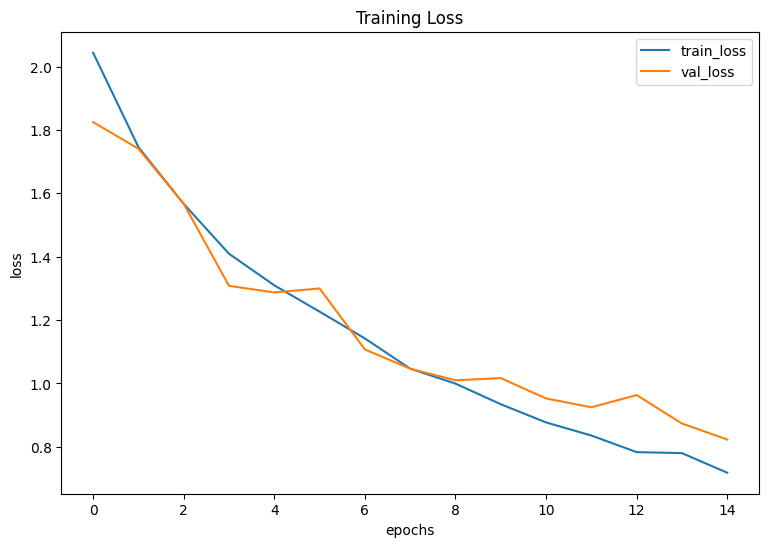

In [24]:


plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])


Test Predictions

In [27]:

test_path = 'C:/Pavel/PythonProject/II_project/test_images'
ds_test = keras.preprocessing.image.ImageDataGenerator(rescale=RESCALE).flow_from_directory(    
    directory=test_path,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    classes=['.'],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [28]:

predict = model.predict(ds_test, verbose=1)

217/217 [==============================] - 46s 214ms/step


In [29]:
predicted_class_indices = np.argmax(predict,axis=1)
print(set(predicted_class_indices))

inv_map = {v:k for k,v in ds_train.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Submission

In [30]:
filenames = ds_test.filenames

submission = pd.DataFrame({ "image_id":filenames, "label":predictions })

submission.image_id = submission.image_id.str.replace('./', '')
submission.to_csv("submission.csv",index=False)
submission.head()

,image_id,label
0,.\200001.jpg,normal
1,.\200002.jpg,normal
2,.\200003.jpg,normal
3,.\200004.jpg,bacterial_leaf_streak
4,.\200005.jpg,blast


In [31]:
submission['label'].value_counts()

normal                      1120
blast                        426
tungro                       394
bacterial_leaf_streak        371
dead_heart                   337
hispa                        294
brown_spot                   290
downy_mildew                  93
bacterial_leaf_blight         83
bacterial_panicle_blight      61
Name: label, dtype: int64

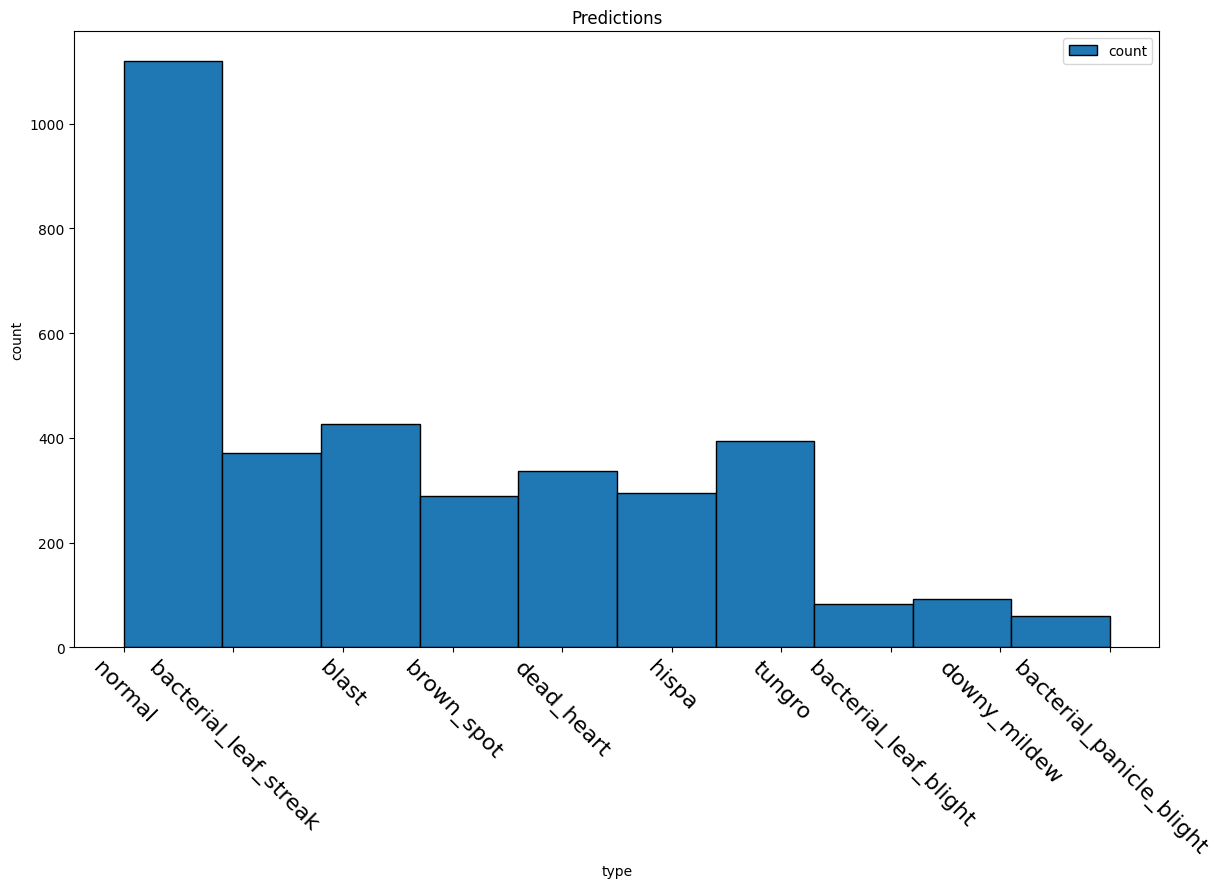

In [51]:
plt.figure(figsize=(14, 8))

plt.hist(submission['label'], edgecolor = 'black')
plt.xticks(rotation = -45, fontsize=16)
plt.title('Predictions')
plt.xlabel('type')
plt.ylabel('count')
plt.legend(['count'])
